## Day 11: Feature Descriptors and MOPS

#### Goals
* Understand the distinction between **feature detection** and **feature description**.
* Know what invariances are desirable for feature descriptors.
* Understand the MOPS (Multi-scale Oriented Patches) descriptor.
* Know how rotation normalization and intensity normalization make MOPS more robust.

In [141]:
# boilerplate setup
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

### Recap: Feature Detection

Last time we learned about the Harris corner detector, which lets us find **interesting points** in an image - points that are locally unique and should be matchable across different views.

But finding a corner location is only half the battle. How do we actually **match** corners between two images?

### Feature Detection vs. Feature Description

The complete feature pipeline has three stages:

1. **Detection**: Find interesting keypoint locations in each image (e.g., Harris corners)
2. **Description**: Extract a descriptor (feature vector) for each keypoint
3. **Matching**: Compare descriptors between images to find correspondences

Today we focus on **description**: given a keypoint location, how do we describe it in a way that:
* Is distinctive enough to match the same point in another image?
* Is robust to changes in viewpoint, lighting, etc.?

##### Discussion Question

What would be a simple feature descriptor for a corner point? What problems might it have?

### Desired Invariances

Recall our desiderata for features:
* **Uniqueness**: features **shouldn't** match if they're from different points
* **Invariance**: features **should** match if they are from the same point

The descriptor needs to be **invariant** to changes that don't fundamentally change the scene point:

**Geometric transformations:**
* Translation
* Rotation
* Scale
* Full viewpoint changes (aspirational!)

**Photometric transformations:**
* Intensity/brightness changes: $I' = I + b$
* Contrast changes: $I' = aI$
* Combined: $I' = aI + b$

### The MOPS Descriptor

**MOPS** = **M**ulti-scale **O**riented **P**atche**s**

The basic idea: describe each keypoint using a small patch of pixels around it, but normalize the patch to be robust to various transformations.

#### MOPS Pipeline:

1. **Extract patch** (e.g., 40×40 pixels) around the keypoint
2. **Rotate** the patch to a canonical orientation (based on gradient direction)
3. **Normalize intensity** (subtract mean, divide by standard deviation)
4. **Subsample** to a smaller descriptor (e.g., 8×8)

The result is a 64-dimensional feature vector (for 8×8) that can be compared between images.

Let's implement each step!

### Step 0: Load image and detect features

First, let's load an image and detect some Harris corners.

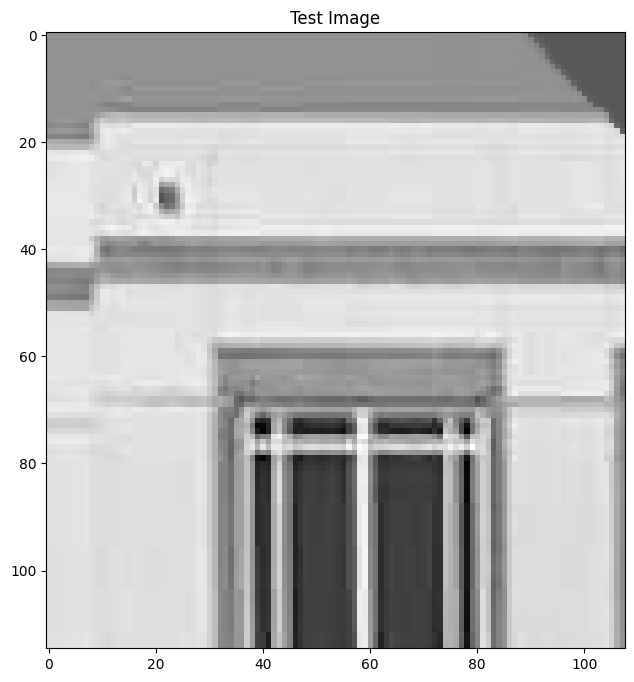

In [142]:
# Load test image
img = cv2.imread("../data/harris_crop.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title("Test Image")
plt.show()

In [143]:
# Helper functions from last class

def compute_gradients(img):
    """ Compute image gradients using OpenCV's Sobel operator. """
    dx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    return dx, dy

def harris_score(img):
    """ Returns the Harris corner score for each pixel. """
    dx, dy = compute_gradients(img)
    
    A = cv2.GaussianBlur(dx * dx, (5, 5), 0)
    B = cv2.GaussianBlur(dx * dy, (5, 5), 0)
    C = cv2.GaussianBlur(dy * dy, (5, 5), 0)

    det = A*C - B*B
    tr = A+C
    
    m = tr / 2
    sqrtm2mp = np.sqrt(np.maximum(m**2 - det, 0))  # clamp to avoid sqrt of negative
    eig1 = m - sqrtm2mp
    eig2 = m + sqrtm2mp
    return np.minimum(eig1, eig2)

def maximum_filter(img, filter_size):
    """ Apply spatial maximum filter. """
    H, W = img.shape
    out = np.zeros_like(img)
    hw = filter_size // 2
    in_pad = np.pad(img, ((hw, hw), (hw, hw)))
    
    for i in range(H):
        for j in range(W):
            out[i,j] = in_pad[i:hw+i+hw+1, j:hw+j+hw+1].max()
    return out

def detect_harris_corners(img, threshold=0.1, nms_size=7):
    """ Detect Harris corners with non-maximum suppression. 
    Returns: feature_mask (boolean array), keypoint_coords (2×N array)
    """
    scores = harris_score(img)
    scores_maxfilter = maximum_filter(scores, nms_size)
    features_mask = np.logical_and(scores > threshold, scores == scores_maxfilter)
    
    # Get coordinates of keypoints as (y, x) pairs
    keypoint_coords = np.array(np.where(features_mask))  # shape: (2, N)
    
    return features_mask, keypoint_coords

In [144]:
# Detect corners
features_mask, keypoints = detect_harris_corners(img, threshold=0.1)

print(f"Detected {keypoints.shape[1]} corner keypoints")
print(f"First few keypoint coordinates (y, x):\n{keypoints[:, :5]}")

Detected 22 corner keypoints
First few keypoint coordinates (y, x):
[[ 18  19  29  39  50]
 [107   7  22  10   7]]


### Step 1: Extract Patch

Given a keypoint location $(x, y)$, extract a square patch of pixels centered at that point.

We'll use a 40×40 pixel patch (this is a common choice in MOPS).

In [145]:
def extract_patch(img, y, x, patch_size=40):
    """ Extract a square patch centered at (y, x).
    
    Args:
        img: grayscale image
        y, x: center coordinates (can be float for subpixel)
        patch_size: size of patch (should be even for symmetric centering)
    
    Returns:
        patch_size × patch_size patch
    """
    half_size = patch_size // 2
    
    # Extract patch (handle boundaries by padding)
    H, W = img.shape
    img_padded = np.pad(img, half_size, mode='constant')
    
    # Adjust coordinates for padding
    y_pad = int(y + half_size)
    x_pad = int(x + half_size)
    
    patch = img_padded[y_pad-half_size:y_pad+half_size, 
                       x_pad-half_size:x_pad+half_size]
    
    return patch

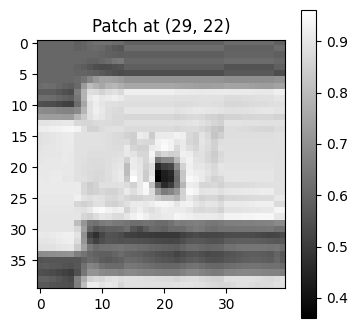

Patch shape: (40, 40)
Patch intensity range: [0.361, 0.961]


In [146]:
# Test on the first detected keypoint
keypoint_index = 2
y0, x0 = keypoints[:, keypoint_index]
patch = extract_patch(img, y0, x0)

plt.figure(figsize=(4, 4))
plt.imshow(patch, cmap='gray')
plt.title(f"Patch at ({y0:.0f}, {x0:.0f})")
plt.colorbar()
plt.show()

print(f"Patch shape: {patch.shape}")
print(f"Patch intensity range: [{patch.min():.3f}, {patch.max():.3f}]")

### Step 2: Rotation Normalization

To achieve rotation invariance, we need to rotate each patch to a **canonical orientation**.

#### How do we find the dominant orientation?

Use the **gradient direction** at the keypoint! The idea:
* Compute image gradients $I_x$, $I_y$
* The gradient angle is $\theta = \arctan2(I_y, I_x)$
* Rotate the patch so this angle becomes 0 (horizontal)

This way, if the same corner appears rotated in another image, we'll rotate its patch back to the same canonical orientation.

In [147]:
def get_dominant_orientation(img, y, x):
    """ Compute the dominant gradient orientation at (y, x). 
    
    Returns:
        angle in radians
    """
    dx, dy = compute_gradients(img)
    
    # Get gradient at the keypoint
    gx = dx[int(y), int(x)]
    gy = dy[int(y), int(x)]
    
    # Compute angle
    angle = np.arctan2(gy, gx)
    
    return angle

def rotate_patch(patch, angle):
    """ Rotate a patch by the given angle (in radians). 
    
    Args:
        patch: square image patch
        angle: rotation angle in radians (counter-clockwise)
    
    Returns:
        rotated patch (same size)
    """
    center = (patch.shape[1] / 2, patch.shape[0] / 2)
    
    # OpenCV rotation: create rotation matrix and apply warp
    M = cv2.getRotationMatrix2D(center, -np.degrees(angle), 1.0)
    rotated = cv2.warpAffine(patch, M, (patch.shape[1], patch.shape[0]))
    
    return rotated

Dominant orientation: -75.3°
Gradient components: gx=0.263, gy=-1.000


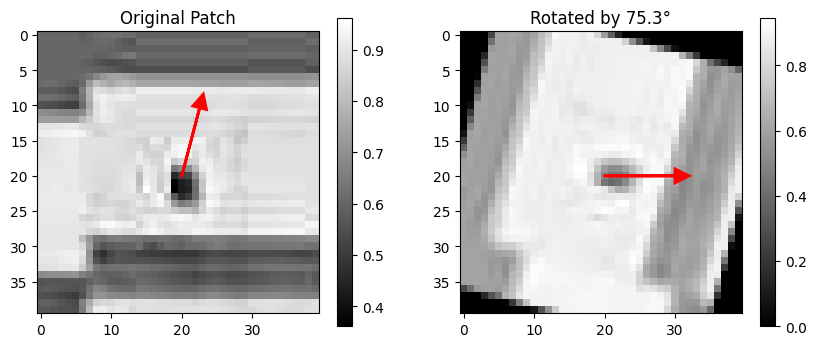

In [148]:
# Test rotation normalization
angle = get_dominant_orientation(img, y0, x0)
patch_rotated = rotate_patch(patch, angle)

# Get the gradient components at the keypoint for visualization
dx, dy = compute_gradients(img)
gx = dx[int(y0), int(x0)]
gy = dy[int(y0), int(x0)]

print(f"Dominant orientation: {np.degrees(angle):.1f}°")
print(f"Gradient components: gx={gx:.3f}, gy={gy:.3f}")

plt.figure(figsize=(10, 4))

# Original patch with gradient arrow
ax1 = plt.subplot(1, 2, 1)
plt.imshow(patch, cmap='gray')
plt.title("Original Patch")
plt.colorbar()

# Draw gradient direction arrow (red) using actual gradient components
center = patch.shape[0] / 2
arrow_scale = 10  # scale factor to make arrow visible
grad_mag = np.sqrt(gx**2 + gy**2)
if grad_mag > 1e-6:
    dx_arrow = arrow_scale * gx / grad_mag
    dy_arrow = arrow_scale * gy / grad_mag
    ax1.arrow(center, center, dx_arrow, dy_arrow, 
             head_width=2, head_length=2, fc='red', ec='red', linewidth=2)

# Rotated patch with gradient arrow (should be horizontal after rotation)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(patch_rotated, cmap='gray')
plt.title(f"Rotated by {-np.degrees(angle):.1f}°")
plt.colorbar()

# After rotating by -angle, the gradient should point horizontally (angle=0)
# Draw horizontal arrow pointing right
ax2.arrow(center, center, arrow_scale, 0, 
         head_width=2, head_length=2, fc='red', ec='red', linewidth=2)

plt.show()

### Step 3: Intensity Normalization

To handle photometric changes (brightness/contrast), we normalize the intensity values:

$$
\text{patch}_{\text{normalized}} = \frac{\text{patch} - \mu}{\sigma}
$$

where $\mu$ is the mean intensity and $\sigma$ is the standard deviation.

This makes the descriptor invariant to:
* **Brightness changes** ($I' = I + b$): subtracting the mean removes the offset
* **Contrast changes** ($I' = aI$): dividing by std deviation removes the scaling

This is the same normalization used in many machine learning pipelines!

In [149]:
def normalize_intensity(patch):
    """ Normalize patch: subtract mean, divide by std deviation. """
    mean = np.mean(patch)
    std = np.std(patch)
    
    # Avoid division by zero for constant patches
    if std < 1e-6:
        return np.zeros_like(patch)
    
    normalized = (patch - mean) / std
    return normalized

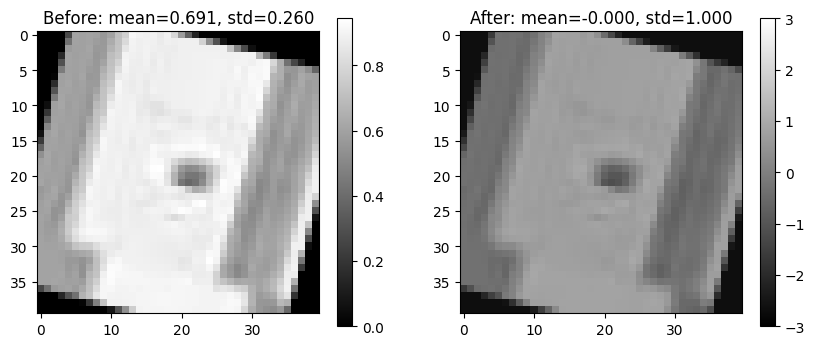

In [150]:
# Test intensity normalization
patch_normalized = normalize_intensity(patch_rotated)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(patch_rotated, cmap='gray')
plt.title(f"Before: mean={np.mean(patch_rotated):.3f}, std={np.std(patch_rotated):.3f}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(patch_normalized, cmap='gray', vmin=-3, vmax=3)
plt.title(f"After: mean={np.mean(patch_normalized):.3f}, std={np.std(patch_normalized):.3f}")
plt.colorbar()
plt.show()

### Step 4: Subsample to Final Descriptor

We don't want to store the full 40×40 patch (1600 dimensions) - that's expensive for matching!

Instead, we **subsample** to a smaller descriptor, typically 8×8 (64 dimensions).

This also provides some additional robustness to small geometric perturbations.

In [151]:
def subsample_patch(patch, descriptor_size=8):
    """ Subsample patch to descriptor_size × descriptor_size. """
    # Use OpenCV's resize with bilinear interpolation
    subsampled = cv2.resize(patch, (descriptor_size, descriptor_size), 
                           interpolation=cv2.INTER_LINEAR)
    return subsampled

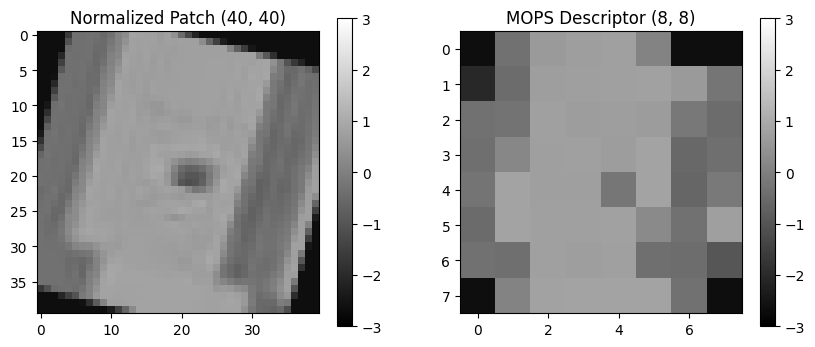

Descriptor as vector: [-2.6582303  -0.31494716  0.6164513   0.7148342   0.7507118   0.11340201
 -2.6582303  -2.6582303  -2.0219808  -0.45221183]... (showing first 10 of 64 values)


In [152]:
# Test subsampling
descriptor = subsample_patch(patch_normalized)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(patch_normalized, cmap='gray', vmin=-3, vmax=3)
plt.title(f"Normalized Patch {patch_normalized.shape}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(descriptor, cmap='gray', vmin=-3, vmax=3, interpolation='nearest')
plt.title(f"MOPS Descriptor {descriptor.shape}")
plt.colorbar()
plt.show()

print(f"Descriptor as vector: {descriptor.flatten()[:10]}... (showing first 10 of {descriptor.size} values)")

### Complete MOPS Pipeline

Let's put it all together into a single function!

In [153]:
def extract_MOPS_descriptor(img, y, x, patch_size=40, descriptor_size=8):
    """ Extract MOPS descriptor for a keypoint.
    
    Args:
        img: grayscale image
        y, x: keypoint coordinates
        patch_size: size of patch to extract
        descriptor_size: size of final descriptor
    
    Returns:
        descriptor: descriptor_size × descriptor_size array
    """
    # Step 1: Extract patch
    patch = extract_patch(img, y, x, patch_size)
    
    # Step 2: Rotate to canonical orientation
    angle = get_dominant_orientation(img, y, x)
    patch_rotated = rotate_patch(patch, angle)
    
    # Step 3: Normalize intensity
    patch_normalized = normalize_intensity(patch_rotated)
    
    # Step 4: Subsample
    descriptor = subsample_patch(patch_normalized, descriptor_size)
    
    return descriptor

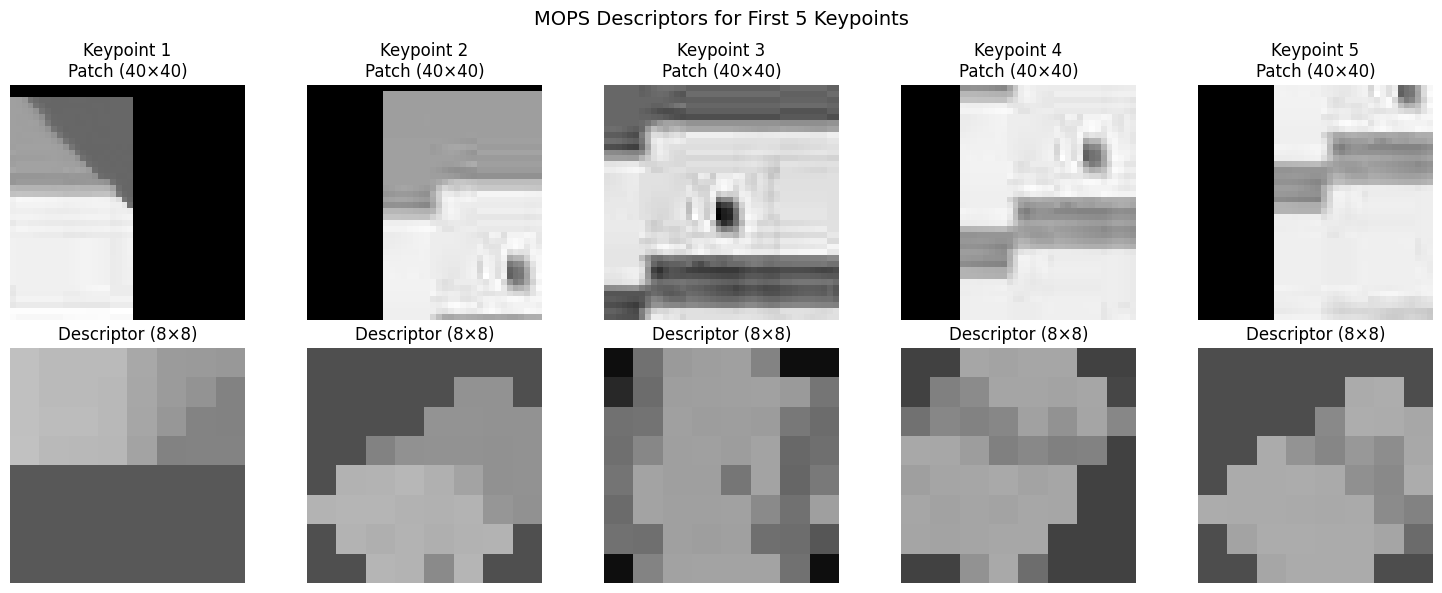

In [154]:
# Extract descriptors for all detected keypoints
descriptors = []
patches = []
for i in range(min(5, keypoints.shape[1])):  # Just do first 5 for visualization
    y, x = keypoints[:, i]
    patch = extract_patch(img, y, x)
    desc = extract_MOPS_descriptor(img, y, x)
    patches.append(patch)
    descriptors.append(desc)

# Visualize the patches and descriptors
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Top row: original 40x40 patches
for i, (patch, ax) in enumerate(zip(patches, axes[0])):
    ax.imshow(patch, cmap='gray')
    ax.set_title(f"Keypoint {i+1}\nPatch (40×40)")
    ax.axis('off')

# Bottom row: MOPS descriptors (8x8)
for i, (desc, ax) in enumerate(zip(descriptors, axes[1])):
    ax.imshow(desc, cmap='gray', vmin=-3, vmax=3, interpolation='nearest')
    ax.set_title(f"Descriptor (8×8)")
    ax.axis('off')

plt.suptitle("MOPS Descriptors for First 5 Keypoints", fontsize=14)
plt.tight_layout()
plt.show()

### Multi-scale: The "M" in MOPS

MOPS stands for **Multi-scale** Oriented Patches. To handle scale changes (e.g., when objects appear larger or smaller in different images), we need to detect and describe features at multiple scales.

**The proper multi-scale approach:**
1. Build a scale pyramid (downsample the image multiple times)
2. Run feature detection (Harris corners) **at each pyramid level**
3. Extract MOPS descriptors at the scale where each feature was detected

This differs from running detection once and describing at multiple scales. Each keypoint is detected at a particular scale and described at that same scale.

**Note:** A limitation of using Harris corners is that the same physical corner can be detected at multiple pyramid levels (corners "repeat across scales"). More advanced detectors like SIFT use Difference of Gaussians (DoG) to select a characteristic scale for each feature, avoiding this repetition.

### Full Demo: Multi-scale MOPS on a Real Image

Let's put it all together on a full-size image to see how multi-scale MOPS works in practice:
1. Build a 3-level scale pyramid
2. Detect Harris corners at each level
3. Extract MOPS descriptors for keypoints from each scale

Original image size: (2160, 3840)
2x downsampled size: (1080, 1920)
4x downsampled size: (540, 960)

Detected corners at each scale:
  1x scale: 2408 corners
  2x scale: 289 corners
  4x scale: 39 corners


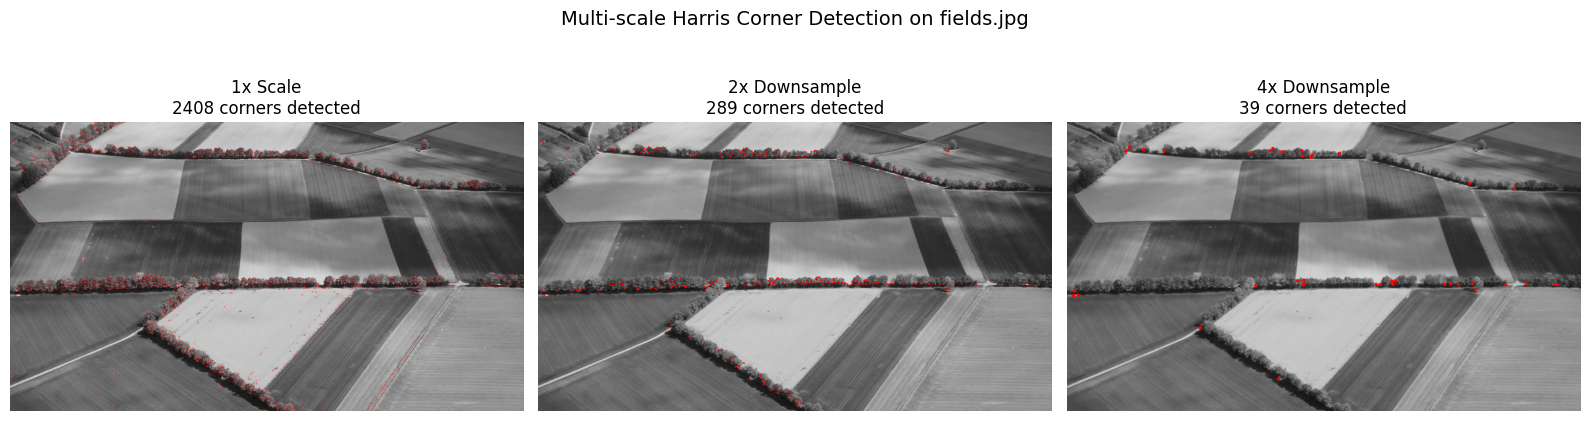

In [158]:
# Load a full-size image
fields = cv2.imread("../data/fields.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255


# Create multi-scale pyramid
fields_2x = cv2.pyrDown(fields)
fields_4x = cv2.pyrDown(fields_2x)

print(f"Original image size: {fields.shape}")
print(f"2x downsampled size: {fields_2x.shape}")
print(f"4x downsampled size: {fields_4x.shape}")

# Run Harris corner detection at EACH scale
# This is the proper multi-scale approach!
fields_mask_1x, fields_kp_1x = detect_harris_corners(fields, threshold=0.3, nms_size=15)
fields_mask_2x, fields_kp_2x = detect_harris_corners(fields_2x, threshold=0.3, nms_size=7)
fields_mask_4x, fields_kp_4x = detect_harris_corners(fields_4x, threshold=0.3, nms_size=5)

print(f"\nDetected corners at each scale:")
print(f"  1x scale: {fields_kp_1x.shape[1]} corners")
print(f"  2x scale: {fields_kp_2x.shape[1]} corners")
print(f"  4x scale: {fields_kp_4x.shape[1]} corners")

# Visualize detected corners at each scale
def overlay_corners(img, keypoints, color=[1, 0, 0]):
    """Overlay detected corners on grayscale image."""
    h, w = img.shape
    out = np.zeros((h, w, 3))
    out[:,:,:] = img[:,:,np.newaxis]
    
    # Draw small circles at keypoint locations
    for i in range(keypoints.shape[1]):
        y, x = keypoints[:, i]
        cv2.circle(out, (int(x), int(y)), 3, color, -1)
    
    return out

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(overlay_corners(fields, fields_kp_1x))
axes[0].set_title(f"1x Scale\n{fields_kp_1x.shape[1]} corners detected", fontsize=12)
axes[0].axis('off')

axes[1].imshow(overlay_corners(fields_2x, fields_kp_2x))
axes[1].set_title(f"2x Downsample\n{fields_kp_2x.shape[1]} corners detected", fontsize=12)
axes[1].axis('off')

axes[2].imshow(overlay_corners(fields_4x, fields_kp_4x))
axes[2].set_title(f"4x Downsample\n{fields_kp_4x.shape[1]} corners detected", fontsize=12)
axes[2].axis('off')

plt.suptitle("Multi-scale Harris Corner Detection on fields.jpg", fontsize=14)
plt.tight_layout()
plt.show()

Selected keypoints:
  From 1x scale detection: (1197, 1559)
  From 2x scale detection: (600, 1086)
  From 4x scale detection: (301, 443)


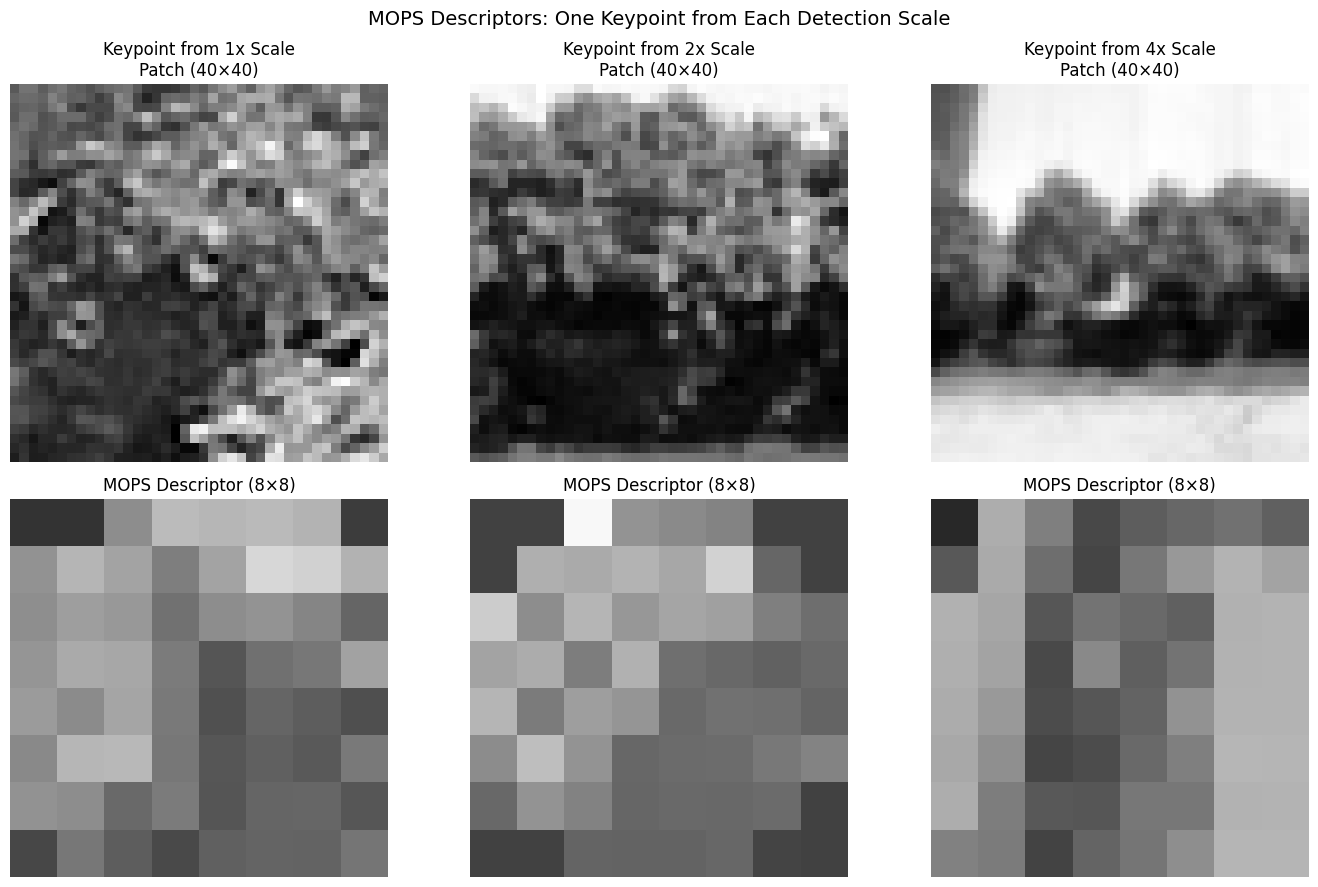

In [159]:
# Pick one keypoint from each scale's detections
# Use a middle keypoint from each scale (sorted by y-coordinate)

# From 1x scale
sorted_1x = np.argsort(fields_kp_1x[0, :])
idx_1x = sorted_1x[len(sorted_1x) // 2]
y_1x, x_1x = fields_kp_1x[:, idx_1x]

# From 2x scale
sorted_2x = np.argsort(fields_kp_2x[0, :])
idx_2x = sorted_2x[len(sorted_2x) // 2]
y_2x, x_2x = fields_kp_2x[:, idx_2x]

# From 4x scale
sorted_4x = np.argsort(fields_kp_4x[0, :])
idx_4x = sorted_4x[len(sorted_4x) // 2]
y_4x, x_4x = fields_kp_4x[:, idx_4x]

print(f"Selected keypoints:")
print(f"  From 1x scale detection: ({y_1x:.0f}, {x_1x:.0f})")
print(f"  From 2x scale detection: ({y_2x:.0f}, {x_2x:.0f})")
print(f"  From 4x scale detection: ({y_4x:.0f}, {x_4x:.0f})")

# Extract patches and descriptors at the scale where each was detected
patch_1x = extract_patch(fields, y_1x, x_1x)
desc_1x = extract_MOPS_descriptor(fields, y_1x, x_1x)

patch_2x = extract_patch(fields_2x, y_2x, x_2x)
desc_2x = extract_MOPS_descriptor(fields_2x, y_2x, x_2x)

patch_4x = extract_patch(fields_4x, y_4x, x_4x)
desc_4x = extract_MOPS_descriptor(fields_4x, y_4x, x_4x)

# Visualize: one keypoint from each scale
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Top row: 40x40 patches
axes[0, 0].imshow(patch_1x, cmap='gray')
axes[0, 0].set_title(f"Keypoint from 1x Scale\nPatch (40×40)", fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(patch_2x, cmap='gray')
axes[0, 1].set_title(f"Keypoint from 2x Scale\nPatch (40×40)", fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(patch_4x, cmap='gray')
axes[0, 2].set_title(f"Keypoint from 4x Scale\nPatch (40×40)", fontsize=12)
axes[0, 2].axis('off')

# Bottom row: 8x8 MOPS descriptors
axes[1, 0].imshow(desc_1x, cmap='gray', vmin=-3, vmax=3, interpolation='nearest')
axes[1, 0].set_title("MOPS Descriptor (8×8)", fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(desc_2x, cmap='gray', vmin=-3, vmax=3, interpolation='nearest')
axes[1, 1].set_title("MOPS Descriptor (8×8)", fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(desc_4x, cmap='gray', vmin=-3, vmax=3, interpolation='nearest')
axes[1, 2].set_title("MOPS Descriptor (8×8)", fontsize=12)
axes[1, 2].axis('off')

plt.suptitle("MOPS Descriptors: One Keypoint from Each Detection Scale", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

### Class Summary

Feature detectors locate keypoints in an image that have distinctive appearance suitable for matching. Feature Descriptors quantify the local appearance around a keypoint. Soon we'll discuss how to match keypoints between multiple images of the same scene.

Good image descriptors are sensitive to the underlying scene appearance. But they are invariant to changes in appearance that are due to how the image was captured, such as viewpoint and lighting.

The MOPS descriptor works like this:

1. **Patch-based representation**: More distinctive than single pixels
2. **Rotation normalization**: Invariant to in-plane rotation (using gradient direction)
3. **Intensity normalization**: Invariant to brightness/contrast changes (mean subtraction, std division)
4. **Subsampling**: Compact representation (64-D) that's robust to small perturbations
5. **Multi-scale**: Handles zoom-in/zoom-out variation by detecting/describing at several scales

Next time: Feature matching! How do we compare these descriptors to find correspondences?